# Simulation game

## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

## Model

In [2]:
class Batch:
    def __init__(self, quantity: int, date_warehouse: int):
        self.quantity = quantity
        self.date_warehouse = date_warehouse

In [3]:
class Warehouse:
    incoming_batch: Batch = None

    def __init__(self, region: str, stock: int, order_point: int, order_quantity: int, fulfilment_costs: dict, factory):
        self.region = region
        self.stock = stock
        self.order_point = order_point
        self.order_quantity = order_quantity
        self.fulfilment_costs = fulfilment_costs
        self.factory = factory

    def init_day(self, visualise, stats):
        # Pay daily holding cost
        stats.costs += self.stock * (100 / 365)

        # Process incoming batch
        if self.incoming_batch is not None and self.incoming_batch.date_warehouse == stats.date:
            self.stock += self.incoming_batch.quantity
            if visualise:
                print(f"📦 {self.region} received batch of {self.incoming_batch.quantity} 🛢️ from 🏭 {self.factory.region}.")
            self.incoming_batch = None

    def finish_day(self, visualise, stats, warehouses):
        if self.stock < self.order_point and self.incoming_batch is None:
            if self.factory.is_busy(stats):
                return
            self.factory.order_batch(self.order_quantity, self.region, visualise, stats, warehouses)

    def can_process_demand(self, quantity: int):
        return self.stock >= quantity

    def process_region_demand(self, quantity: int, region: str, visualise, stats):
        # Stock
        self.stock -= quantity

        # Costs and revenue
        stats.costs += self.fulfilment_costs[region] * quantity
        revenue = 1450 * quantity
        stats.revenue += revenue

        # Logs
        if visualise:
            print(f"""📦 Warehouse {self.region} fulfilled order for {quantity} 🛢️ from {region}.
            -> stock {self.stock:,}
            +💲{revenue:,}""")

In [4]:
class Factory:
    busy_until = -1

    def __init__(self, region: str, capacity: int, shipping_info: dict):
        self.region = region
        self.capacity = capacity
        self.shipping_info = shipping_info
    
    def order_batch(self, quantity: int, region: str, visualise, stats, warehouses):        
        # Mark dates as busy. No half-day production (round up).
        busy_days = math.ceil(quantity / self.capacity)
        self.busy_until = stats.date + busy_days

        # Shipping options
        shipping_info = self.shipping_info[region]
        shipping_method = shipping_info["method"]

        # Create Batch object
        shipping_days = shipping_info[shipping_method]["duration"]
        date_warehouse = stats.date + busy_days + shipping_days
        batch = Batch(quantity=quantity,
                      date_warehouse=date_warehouse)
        warehouses[region].incoming_batch = batch

        # Count costs
        shipping_base_cost = shipping_info[shipping_method]["cost"]
        shipping_costs = shipping_base_cost * quantity if shipping_method == "mail" else math.ceil(quantity / 200) * shipping_base_cost
        costs = 1500 + quantity * 1000 + shipping_costs
        stats.costs += costs

        # Logs
        if visualise:
            print(f"""🏭 {self.region} received order from 📦 {region} for {quantity} 🛢️.
            -> warehouse on day {date_warehouse}
            -💲{costs:,}""")
    
    def is_busy(self, stats):
        return self.busy_until > stats.date

In [5]:
class Stats:
    def __init__(self, demand):
        self.x = list(range(min(demand.keys()), max(demand.keys()) + 1))
        self.stock = {
            "calopeia": [],
            "sorange": [],
            "tyran": [],
            "entworpe": [],
            "fardo": []
        }
        self.lost_demand = {
            "calopeia": [],
            "sorange": [],
            "tyran": [],
            "entworpe": [],
            "fardo": []
        }
        self.costs = 0
        self.revenue = 0
        self.date = -1

    def get_profit(self):
        return self.revenue - self.costs
    
    def update(self, warehouses):
        # Update stock
        length = -1
        for warehouse in warehouses.values():
            self.stock[warehouse.region].append(warehouse.stock)
            length = len(self.stock[warehouse.region])
        
        # Update lost demand
        for region in self.lost_demand.keys():
            if len(self.lost_demand[region]) < length:
                self.lost_demand[region].append(np.nan)

    def register_lost_demand(self, quantity: int, region: str, visualise):
        self.lost_demand[region].append(quantity)
        if visualise:
            print(f"🚩🚩🚩 Demand of {quantity} 🛢️ from {region} not fulfilled 🚩🚩🚩")

    def get_total_lost_demand(self):
        total_lost_demand = 0
        for lost_demand in self.lost_demand.values():
            total_lost_demand += np.nansum(lost_demand)
        
        return int(total_lost_demand)

    def visualise(self, warehouses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        fig.tight_layout()

        # Visualise stock
        for warehouse in warehouses.values():
            ax1.plot(self.x, self.stock[warehouse.region], label=warehouse.region)

        ax1.set_xlim((min(self.x) - 0.5, max(self.x) + 0.5))
        ax1.set_ylabel('Stock')
        ax1.set_title('Stock and lost demand over time')

        # Visualise lost demand
        for region in self.lost_demand.keys():
            ax2.scatter(self.x, self.lost_demand[region], label=region, s=15)

        ax2.set_xlim((min(self.x) - 0.5, max(self.x) + 0.5))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Lost demand')

        print(f"\n🛑 Lost demand: {self.get_total_lost_demand():,}")
        print(f"💲 Total cost: {int(self.costs):,}")
        print(f"💸 Revenue: {self.revenue:,}")
        print(f"💰 Profit: {int(self.revenue - self.costs):,}")

        plt.show()

In [6]:
def simulate(demand, warehouses, factories, visualise=True):
    stats = Stats(demand)
    for date in range(min(demand.keys()), max(demand.keys()) + 1):
        if visualise:
            print(f"\n--- 📅 Day {date} ---\n")
        stats.date = date

        # Update warehouses
        for warehouse in warehouses.values():
            warehouse.init_day(visualise, stats)

        # Process demand
        daily_demand = demand[date]
        for region, region_demand in daily_demand.items():
            whs = [warehouse for warehouse in warehouses.values() if region in warehouse.fulfilment_costs]
            preferred_warehouses = [(warehouse, warehouse.fulfilment_costs[region]) for warehouse in whs]
            preferred_warehouses.sort(key=lambda x: x[1])
            preferred_warehouses = [wh[0] for wh in preferred_warehouses]
            
            demand_fulfilled = False
            for warehouse in preferred_warehouses:
                if warehouse.can_process_demand(region_demand):
                    warehouse.process_region_demand(region_demand, region, visualise, stats)
                    demand_fulfilled = True
                    break
            if not demand_fulfilled:
                stats.register_lost_demand(region_demand, region, visualise)
        
        # Update warehouses once again
        for warehouse in warehouses.values():
            warehouse.finish_day(visualise, stats, warehouses)

        # Update stats
        stats.update(warehouses)
    
    if visualise:
        stats.visualise(warehouses)

    return stats

## Simulation


--- 📅 Day 1431 ---

📦 Warehouse calopeia fulfilled order for 3 🛢️ from calopeia.
            -> stock 177
            +💲4,350
📦 Warehouse sorange fulfilled order for 131 🛢️ from sorange.
            -> stock 69
            +💲189,950
📦 Warehouse calopeia fulfilled order for 17 🛢️ from tyran.
            -> stock 160
            +💲24,650
📦 Warehouse calopeia fulfilled order for 16 🛢️ from entworpe.
            -> stock 144
            +💲23,200
📦 Warehouse fardo fulfilled order for 17 🛢️ from fardo.
            -> stock 203
            +💲24,650
🏭 calopeia received order from 📦 calopeia for 90 🛢️.
            -> warehouse on day 1433
            -💲105,000
🏭 sorange received order from 📦 sorange for 100 🛢️.
            -> warehouse on day 1434
            -💲116,500
🏭 fardo received order from 📦 fardo for 0 🛢️.
            -> warehouse on day 1432
            -💲1,500

--- 📅 Day 1432 ---

📦 fardo received batch of 0 🛢️ from 🏭 fardo.
📦 Warehouse calopeia fulfilled order for 38 🛢️ from calopei

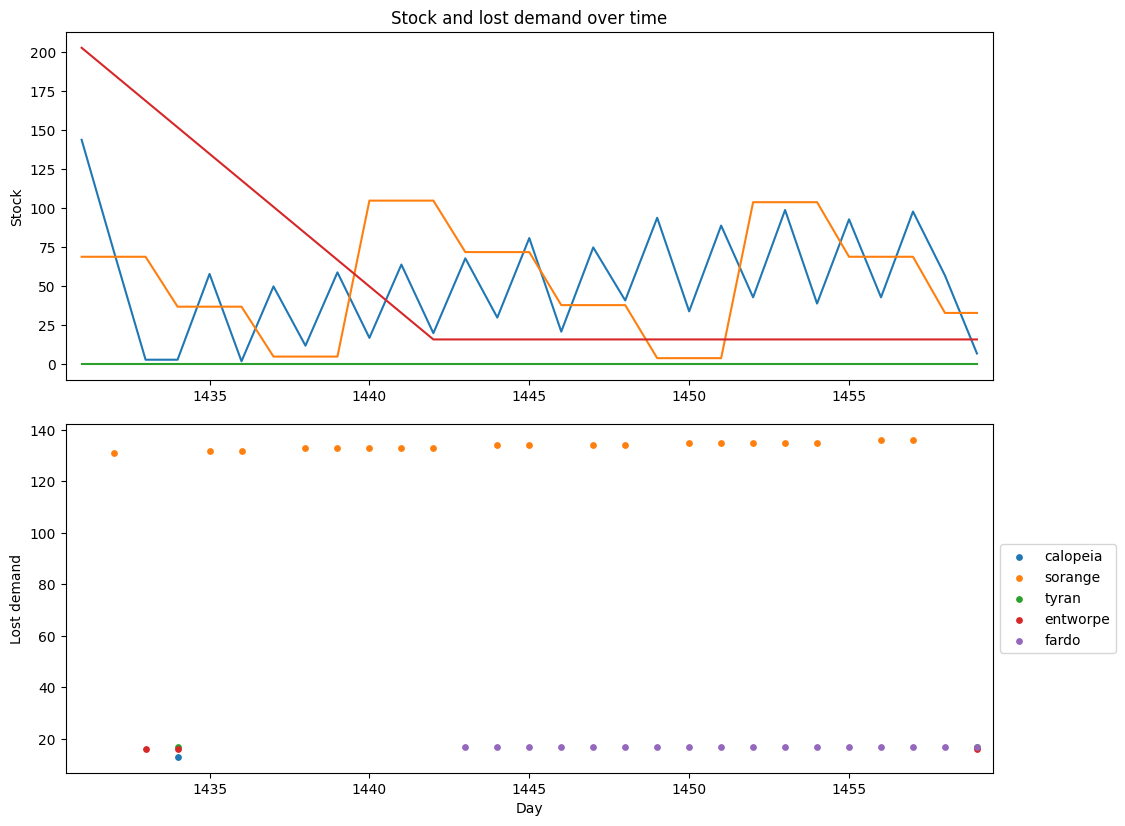

667119.3150684941
2927


In [89]:
with open("2_year_forecast.json") as f:
    demand_param = json.load(f)

demand_dict = dict()
for key, value in demand_param.items():
    demand_dict[int(key)] = value

demand_param = demand_dict
demand_param = {key: value for key, value in demand_param.items() if key > 1430 and key < 1460}


factories_param = {
    "calopeia": Factory(
        region="calopeia", 
        capacity=90,
        shipping_info={
            "calopeia": {
                "mail": {
                    "cost": 150,
                    "duration": 1
                },
                "truck": {
                    "cost": 15000,
                    "duration": 7
                },
                "method": "mail"
            },
            "entworpe": {
                "mail": {
                    "cost": 200,
                    "duration": 1
                },
                "truck": {
                    "cost": 20000,
                    "duration": 7
                },
                "method": "truck"
            }
        }),

    "sorange": Factory(
        region="sorange", 
        capacity=85,
        shipping_info={
            "sorange": {
                "mail": {
                    "cost": 150,
                    "duration": 1
                },
                "truck": {
                    "cost": 15000,
                    "duration": 7
                },
                "method": "mail"
            }
        }),

    "fardo": Factory(
        region="fardo", 
        capacity=19, 
        shipping_info={
            "fardo": {
                "mail": {
                    "cost": 150,
                    "duration": 1
                },
                "truck": {
                    "cost": 15000,
                    "duration": 7
                },
                "method": "mail"
            }
        }
)        
}

warehouses_param = {
    "calopeia": Warehouse(
        region="calopeia", 
        stock=180,
        order_point=800,
        order_quantity=90,
        factory=factories_param['calopeia'],   
        fulfilment_costs={
            "calopeia": 150,
            "sorange": 200,
            "tyran": 200,
            "entworpe": 200
        }),
    "sorange": Warehouse(
        region="sorange", 
        stock=200,
        order_point=500,
        order_quantity=100,
        factory=factories_param['sorange'],   
        fulfilment_costs={
            "sorange": 150
        }),
    "entworpe": Warehouse(
        region="entworpe",
        stock=0,
        order_point=499,
        order_quantity=0,
        factory=factories_param['calopeia'],   
        fulfilment_costs={
            "entworpe": 150
        }),
    "fardo": Warehouse(
        region="fardo", 
        stock=220,
        order_point=250, 
        order_quantity=0,
        factory=factories_param['fardo'],   
        fulfilment_costs={
            "fardo": 150
        })
}

stats = simulate(demand_param, warehouses_param, factories_param, visualise=True)
print(stats.get_profit())
print(stats.get_total_lost_demand())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c1ad54d7-9537-4118-b23c-780e518ab074' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>